# Neural Efficiency Analysis
In this notebook we explore the neural efficiency metric with quantized models.

In [1]:
%reload_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import ast
import os
import sys
from statistics import mean
import warnings


# import modules from JTAG model
module_path = os.path.abspath(os.path.join('../../workspace/models/jets/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import model as jet_tagger
import jet_datamodule

# import modules from ECON model
module_path = os.path.abspath(os.path.join('../../workspace/models/econ/code/')) # or the path to your source code
sys.path.insert(0, module_path)
import q_autoencoder as econ
import autoencoder_datamodule

# import modules from common metrics
module_path = os.path.abspath(os.path.join('../../workspace/common/metrics/')) # or the path to your source code
sys.path.insert(0, module_path)
from neural_efficiency import NeuralEfficiency



/opt/conda/envs/loss_landscape/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Utility methods

In [2]:
def plot_2d_heatmap(values, 
                    title, 
                    min_max=(0, 1), 
                    x_label='Layers', 
                    y_label='Layers', 
                    scale_label='Value', 
                    cmap='Greens',
                    show_value=True):
    '''
    Method used to plot a 2D heatmap using Seaborn.
    '''
    # Set up the figure and axes
    plt.figure(figsize=(7, 6))

    # Create a heatmap using Seaborn
    sns.heatmap(values, 
                cmap=cmap, 
                annot=show_value, 
                fmt=".2f", 
                vmin=min_max[0], 
                vmax=min_max[1],
                cbar_kws={'label': scale_label})

    # Customize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Display the plot
    plt.show()
    
def plot_neural_efficiency_per_layer(neural_efficiency_values, 
                                     title, 
                                     x_label='Layers', 
                                     y_label='Efficiency'):
    plt.figure(figsize=(12,6))
    
    plt.bar(neural_efficiency_values.keys(), 
            neural_efficiency_values.values())

    plt.ylim(0, 1)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Display the plot
    plt.show()

In [3]:
# search space
batch_sizes = [16, 32, 64, 128, 256, 512, 1024]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]
precisions = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
ne_batch_num = 50000

# ECON model (Autoencoder)
we focus our analysis on the encoder which will be deploy on an ASIC.

In [14]:
DATA_PATH = '/home/jovyan/checkpoint/'
DATASET_DIR = '../../data/ECON/Elegun'
DATASET_FILE = 'nELinks5.npy'

size = 'baseline'
ECON_layers = ['encoder.conv', 'encoder.enc_dense']
# we do not consider extreme low precisions due to their performances
precisions = [3, 4, 5, 6, 7, 8, 9, 10, 11]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]



In [15]:
def get_neural_efficiency(batch_size, 
                          learning_rate, 
                          precision,
                          size, 
                          dataloader,
                          load=True,
                          max_batches=None,
                          beta=-2):
    '''
    Get the value of the Neural Efficiency
    '''
    
    # path to the directory
    path = os.path.join(
        DATA_PATH, 
        f'bs{batch_size}_lr{learning_rate}/ECON_{precision}b/{size}/'
    )
    
    # load the model and the performance
    model, emd = econ.load_model(batch_size, learning_rate, precision, size)
    
    # instantiate the metric
    metric = NeuralEfficiency(model, 
                              dataloader, 
                              performance=emd, 
                              max_batches=max_batches,
                              target_layers=ECON_layers)
    
    # try to load the result
    if load:
        if metric.load_from_file(path):
            return metric.results
        else:
            print("Information not stored in ", path)
    
    # compute the result and store it
    result = metric.compute(beta=beta)
    metric.save_on_file(path=path)
    
    return result

## Results

Neural efficiency require to process an input sample per time. 

In [16]:
noise = 5 # 5 10 15 20
noise_type = 'gaussian'
ne_dataloader = autoencoder_datamodule.get_data_module(DATASET_DIR, DATASET_FILE, 1).test_dataloader()

File neural_efficiency.pkl not found!


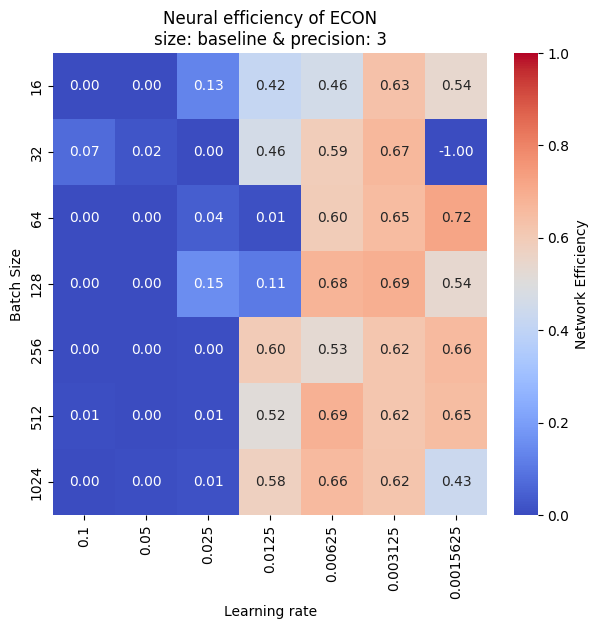

File neural_efficiency.pkl not found!


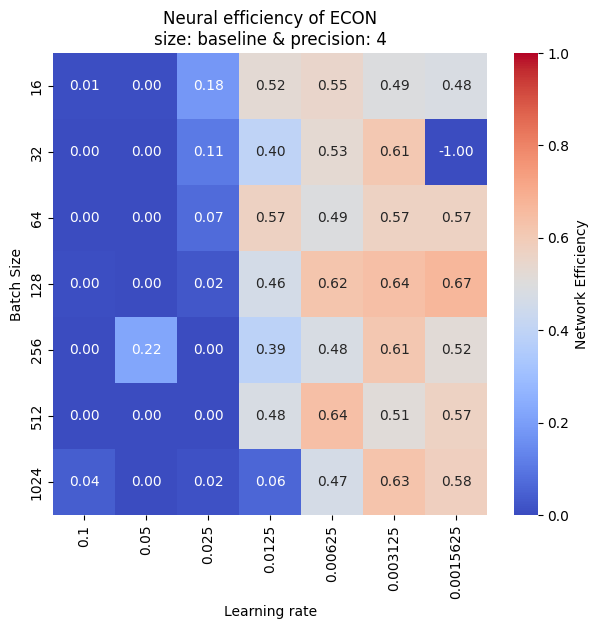

File neural_efficiency.pkl not found!


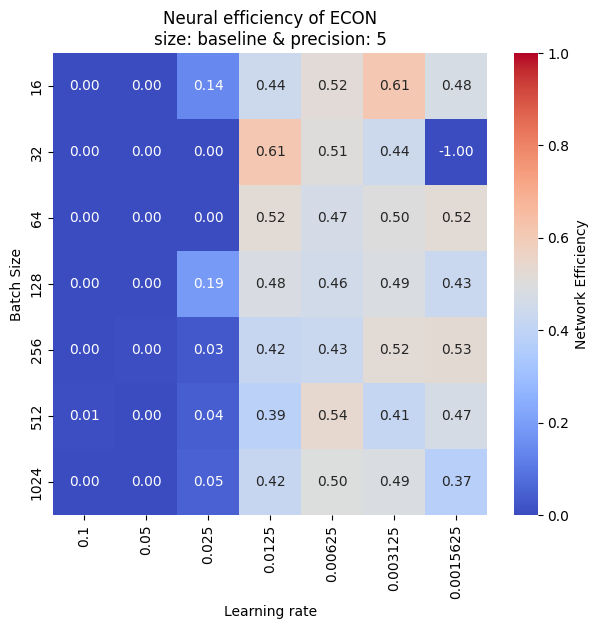

File neural_efficiency.pkl not found!


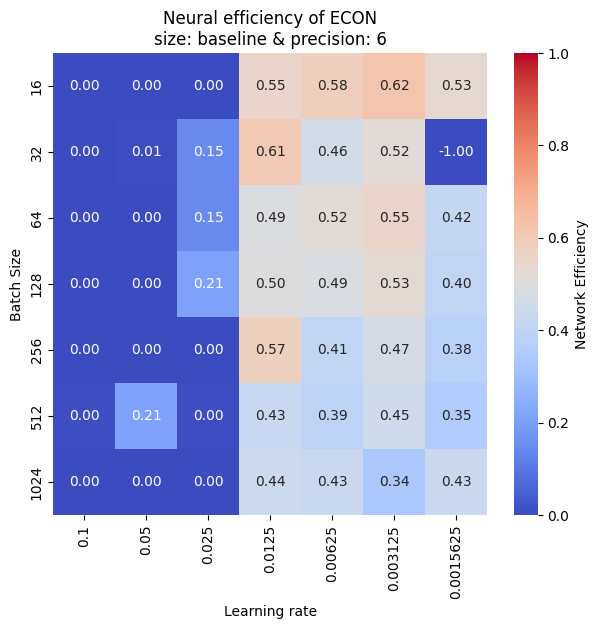

File neural_efficiency.pkl not found!


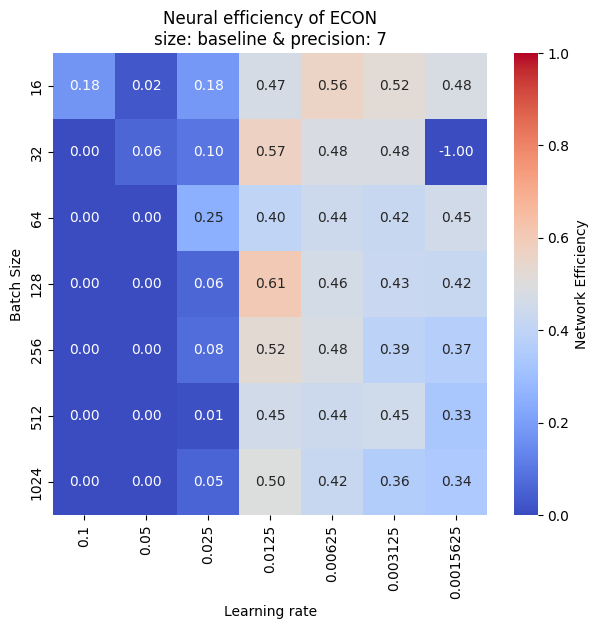

File neural_efficiency.pkl not found!


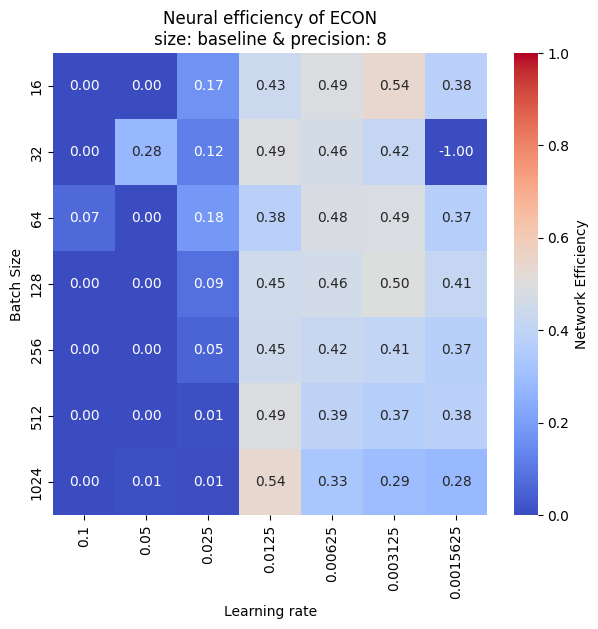

File neural_efficiency.pkl not found!


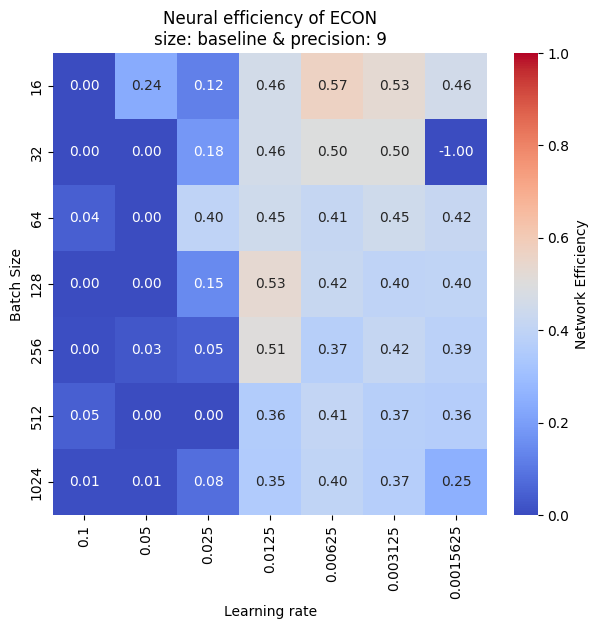

File neural_efficiency.pkl not found!


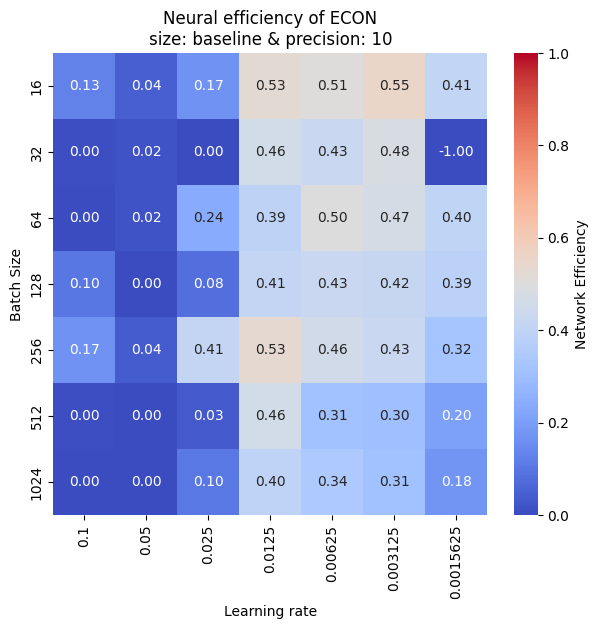

File neural_efficiency.pkl not found!


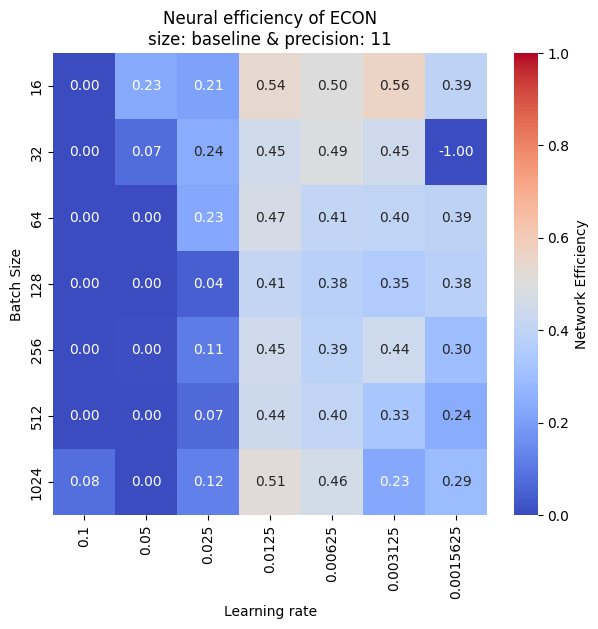

In [17]:
ne_distribution = []
for p in precisions:
    NE_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            
            # get the performances with and without noise
            mean_emd, _ = econ.get_model_index_and_relative_EMD(DATA_PATH, bs, lr, p, size)
            noise_emd = econ.get_emd_with_noise(DATA_PATH, bs, lr, p, size, noise_type, noise)
            
            # get the model
            model, _ = econ.load_model(DATA_PATH, bs, lr, p, size)
    
            # instantiate the metric
            metric = NeuralEfficiency(model, 
                                      ne_dataloader, 
                                      performance=mean_emd, 
                                      max_batches=ne_batch_num,
                                      target_layers=ECON_layers)
            
            # load the value from the file
            path = os.path.join(
                DATA_PATH, 
                f'bs{bs}_lr{lr}/ECON_{p}b/{size}/'
            )
            result = -1
            if metric.load_from_file(path):
                result = metric.results['network_efficiency']
            
            # build the heatmap matrix
            NE_matrix[x, y] = result
            
            # build the dataframe for further analysis
            ne_distribution.append({
                'precision': p, 
                'net_efficiency': result,
                'emd': mean_emd,
                'noise_emd': noise_emd,
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': (noise_emd - mean_emd) * 100 / mean_emd,
            })
            
    # plot the heatmaps per precision
    NE_matrix = pd.DataFrame(NE_matrix, 
                             index=batch_sizes, 
                             columns=learning_rates)
    plot_2d_heatmap(NE_matrix, 
                    f'Neural efficiency of ECON\nsize: {size} & precision: {p}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'Network Efficiency',
                    cmap='coolwarm')
    

In [18]:
ne_distribution_df = pd.DataFrame(ne_distribution)

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

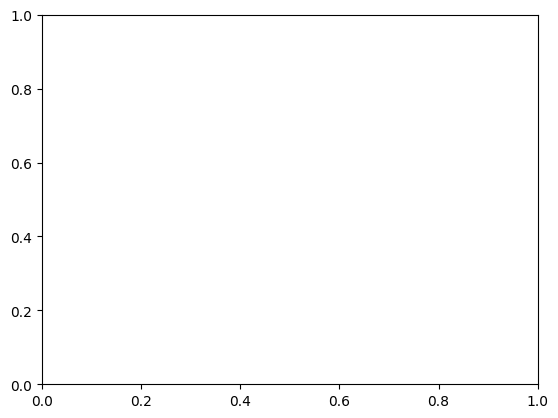

In [19]:
top_5_df = ne_distribution_df.loc[
        (ne_distribution_df.batch_size == '32') & (ne_distribution_df.learning_rate == '0.003125') |
        (ne_distribution_df.batch_size == '128') & (ne_distribution_df.learning_rate == '0.0015625') |
        (ne_distribution_df.batch_size == '32') & (ne_distribution_df.learning_rate == '0.0015625') |
        (ne_distribution_df.batch_size == '16') & (ne_distribution_df.learning_rate == '0.0015625') |
        (ne_distribution_df.batch_size == '64') & (ne_distribution_df.learning_rate == '0.003125')
    ]

hue = top_5_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_5_df, x='precision', y='net_efficiency', hue=hue)
plt.title("Network efficiency of the best models at different precisions")
plt.show()

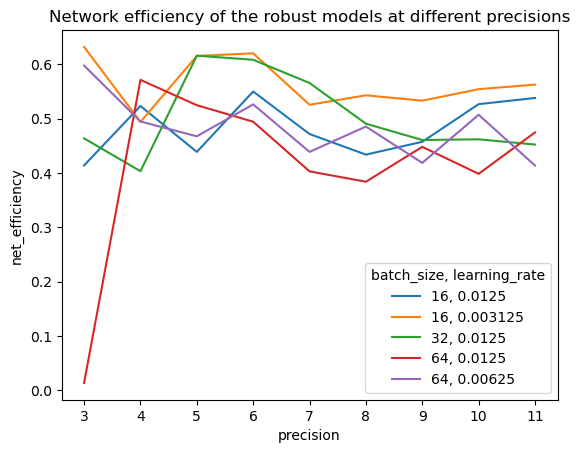

In [ ]:
top_5_df = ne_distribution_df.loc[
        (ne_distribution_df.batch_size == '16') & (ne_distribution_df.learning_rate == '0.003125') |
        (ne_distribution_df.batch_size == '64') & (ne_distribution_df.learning_rate == '0.00625') |
        (ne_distribution_df.batch_size == '16') & (ne_distribution_df.learning_rate == '0.0125') |
        (ne_distribution_df.batch_size == '32') & (ne_distribution_df.learning_rate == '0.0125') |
        (ne_distribution_df.batch_size == '64') & (ne_distribution_df.learning_rate == '0.0125')
    ]

hue = top_5_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_5_df, x='precision', y='net_efficiency', hue=hue)
plt.title("Network efficiency of the robust models at different precisions")
plt.show()

## Per layer analysis

In [ ]:
MIN_EMD = 3
MAX_LOSS = 50
NUM_PLOT = 3

ne_distribution_df = ne_distribution_df.loc[
        (ne_distribution_df.loss > -0.5) & 
        (ne_distribution_df.emd < MIN_EMD) # &
        # (ne_distribution_df.loss < MAX_LOSS)
    ]
ne_distribution_df.sort_values(by='loss', ascending=True, inplace=True)

--------------------------------------------------------------------------------
Low loss
Accuracy:	1.7443809111913045
Loss:	-0.2568909484347166
Network efficiency:	0.5679992516557305


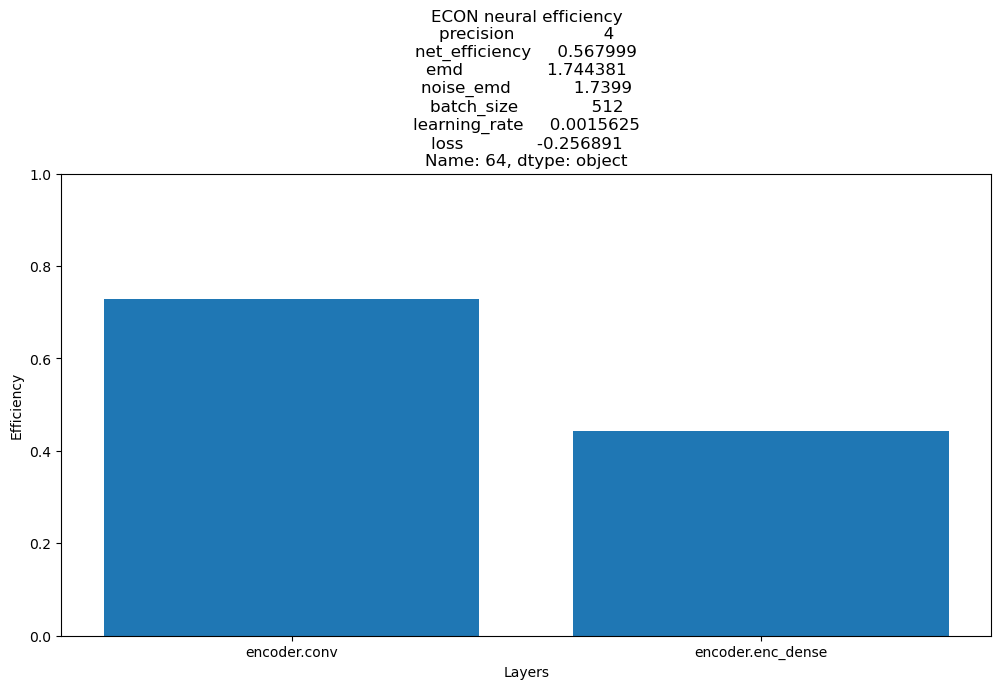

--------------------------------------------------------------------------------
Low loss
Accuracy:	1.860877513885498
Loss:	3.1380067876381372
Network efficiency:	0.6317732287609304


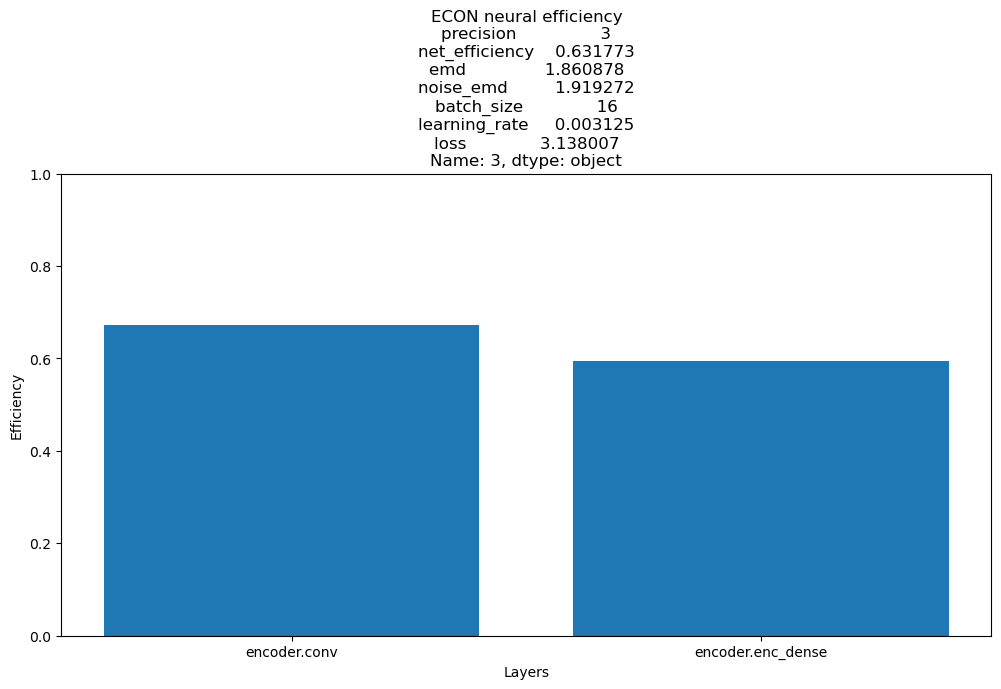

--------------------------------------------------------------------------------
Low loss
Accuracy:	1.9190647999445598
Loss:	4.798360785779066
Network efficiency:	0.5975000562322365


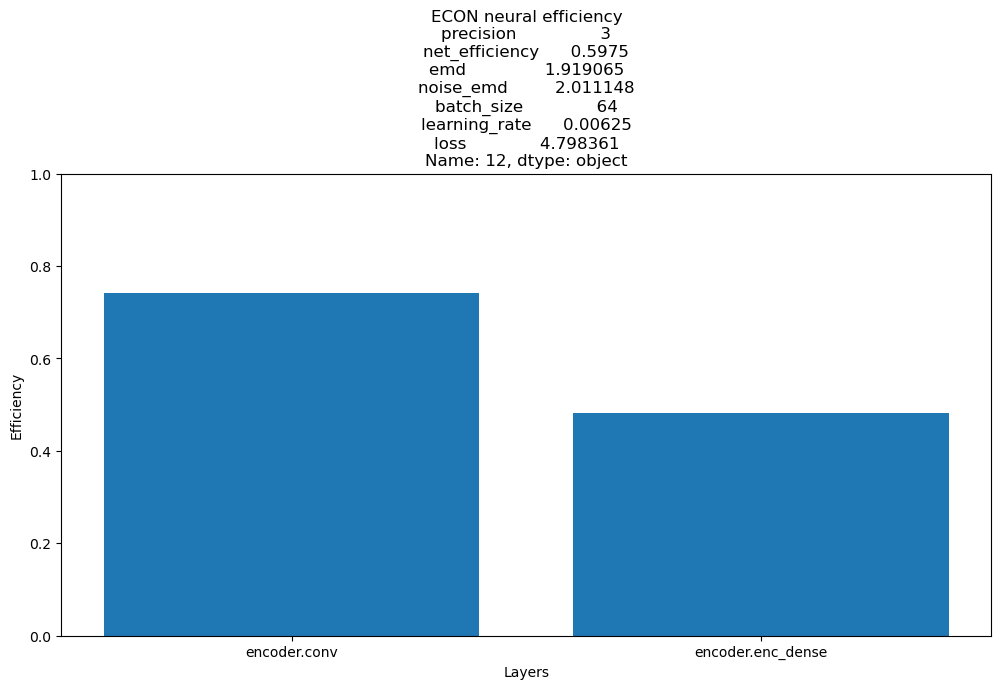

In [ ]:
best_df = ne_distribution_df.head(NUM_PLOT)
for i in range(NUM_PLOT):
    print('-'*80)
    print('Low loss')
    result = get_neural_efficiency(int(best_df.iloc[i]['batch_size']),
                                   float(best_df.iloc[i]['learning_rate']), 
                                   int(best_df.iloc[i]['precision']),
                                   size,
                                   ne_dataloader,
                                   max_batches=ne_batch_num)
    print(f"EMD:\t{best_df.iloc[i]['emd']}\n" \
          f"Loss:\t{best_df.iloc[i]['loss']}\n" \
          f"Network efficiency:\t{best_df.iloc[i]['net_efficiency']}")

    plot_neural_efficiency_per_layer(result['layers_efficiency'], 
                                     'ECON neural efficiency\n' \
                                     f'{best_df.iloc[i]}')

--------------------------------------------------------------------------------
High loss
Accuracy:	1.3663277626037598
Loss:	252.22089644122613
Network efficiency:	0.4475942992885123


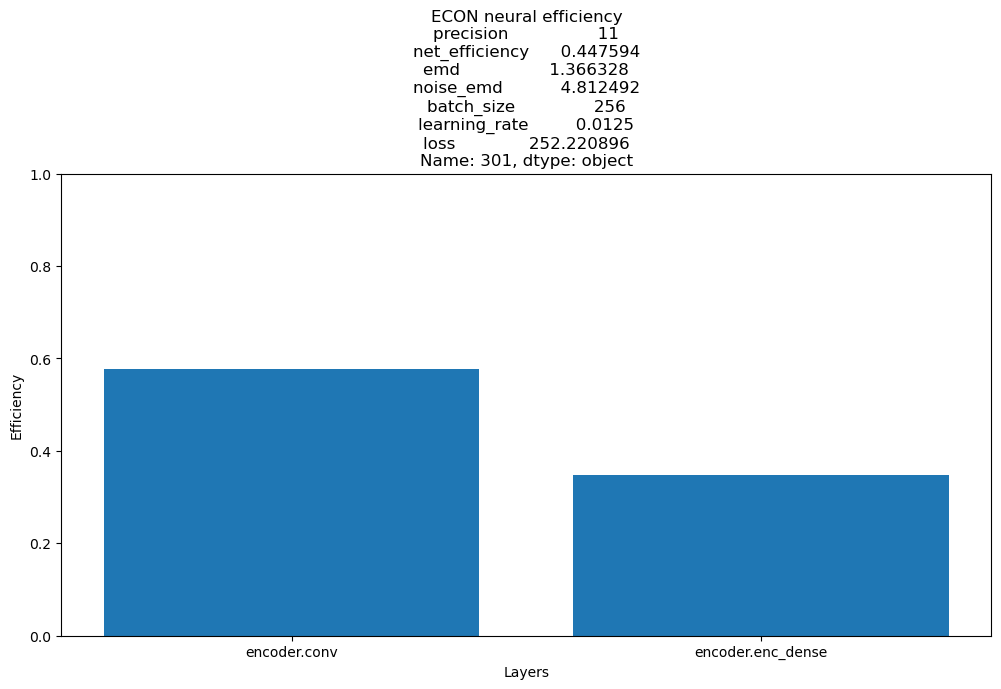

--------------------------------------------------------------------------------
High loss
Accuracy:	1.1998576720555623
Loss:	269.65530552378385
Network efficiency:	0.4588307921757274


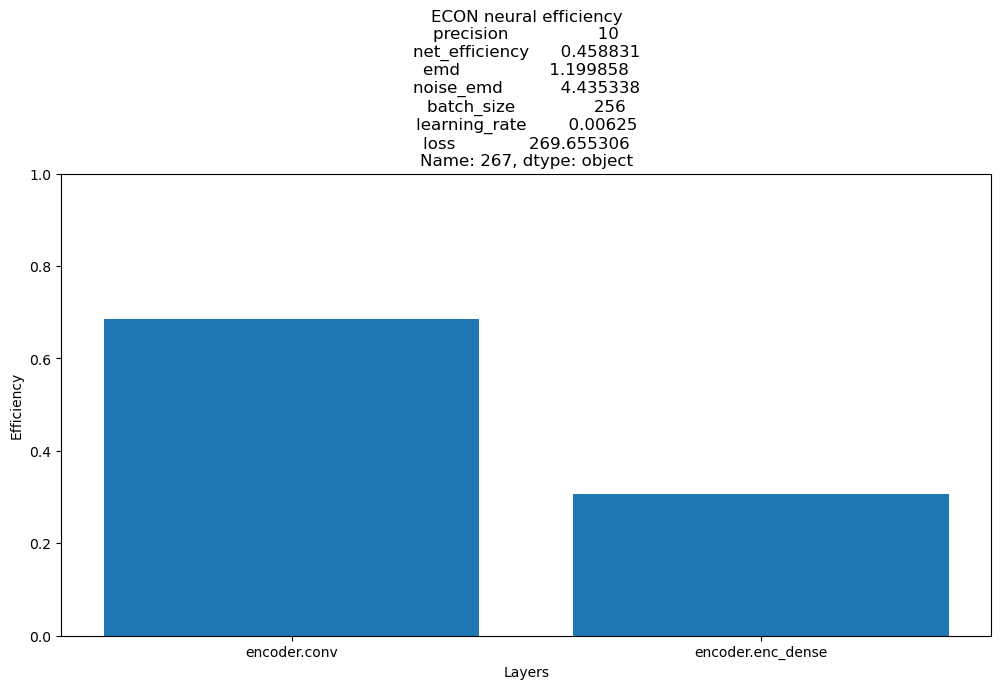

--------------------------------------------------------------------------------
High loss
Accuracy:	1.2699809869130452
Loss:	273.59714379027014
Network efficiency:	0.5712562010228729


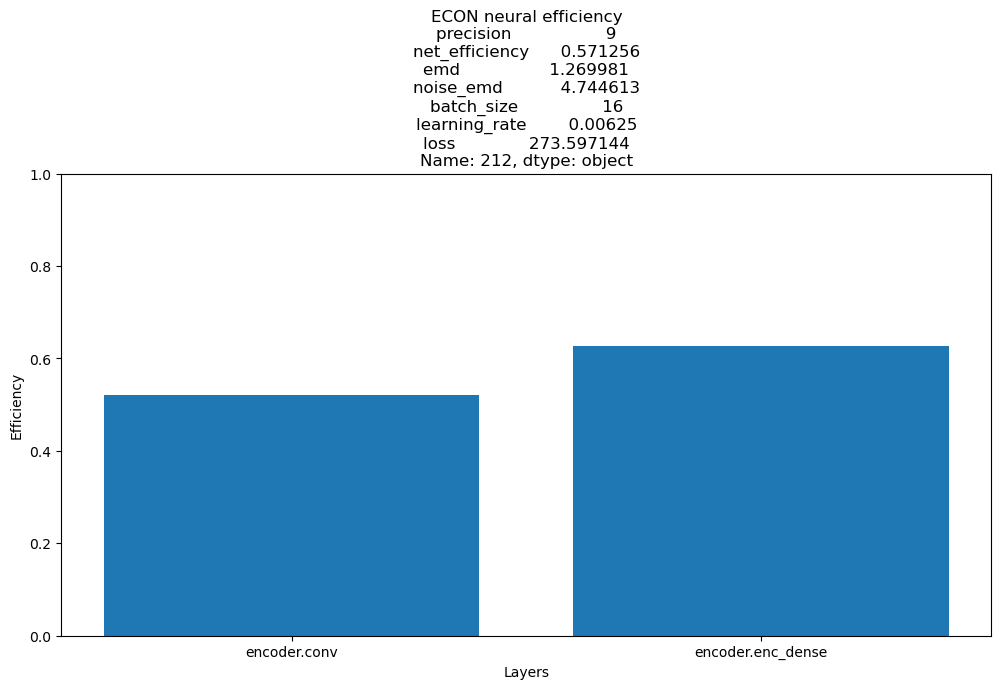

In [ ]:
worst_df = ne_distribution_df.tail(NUM_PLOT)

for i in range(NUM_PLOT):
    print('-'*80)
    print('High loss')
    result = get_neural_efficiency(int(worst_df.iloc[i]['batch_size']),
                                   float(worst_df.iloc[i]['learning_rate']), 
                                   int(worst_df.iloc[i]['precision']),
                                   size,
                                   ne_dataloader,
                                   max_batches=ne_batch_num)
    print(f"Accuracy:\t{worst_df.iloc[i]['emd']}\n" \
          f"Loss:\t{worst_df.iloc[i]['loss']}\n" \
          f"Network efficiency:\t{worst_df.iloc[i]['net_efficiency']}")

    plot_neural_efficiency_per_layer(result['layers_efficiency'], 
                                     'ECON neural efficiency\n' \
                                     f'{worst_df.iloc[i]}')

# Jet Tagger (MLP)
The full precision model achieve 76% of accuracy.

In [ ]:
DATA_PATH="/home/jovyan/checkpoint/"    
DATASET_DIR="../../data/JTAG"
DATASET_FILE=DATASET_DIR + "/processed_dataset.h5"

JTAG_layers = ['model.dense_1', 'model.dense_2', 'model.dense_3', 'model.dense_4']
# we do not consider extreme low precisions due to their performances
precisions = [4, 5, 6, 7, 8, 9, 10, 11]
learning_rates = [0.1, 0.05, 0.025, 0.0125, 0.00625, 0.003125, 0.0015625]

In [ ]:
def get_data_module(batch_size, num_workers=12):
    '''
    Method used to get the data modules used during the tests
    '''
    data_module = JetDataModule(
        data_dir=DATASET_DIR,
        data_file=os.path.join(DATASET_DIR, DATASET_FILE),
        batch_size=batch_size,
        num_workers=num_workers)
    
    # check if we have processed the data
    if not os.path.exists(os.path.join(DATASET_DIR, DATASET_FILE)):
        print('Processing the data...')
        data_module.process_data(save=True)

    data_module.setup(0)
    return data_module


def load_model(batch_size, learning_rate, precision):
    '''
    Method used to get the model and the relative accuracy
    '''
    accuracy, idx = get_model_index_and_relative_accuracy(batch_size, learning_rate, precision)
    model_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/JTAG_{precision}b/net_{idx}_best.pkl'
    
    # load the model
    model = JetTagger(
        quantize=(precision < 32),
        precision=[
            precision,
            precision,
            precision+3
        ],
        learning_rate=learning_rate,
    )
    
    # to set the map location
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model(torch.randn((16, 16)))  # Update tensor shapes 
    model_param = torch.load(model_path, map_location=device)
    model.load_state_dict(model_param['state_dict'])
    
    return model, accuracy


def get_model_index_and_relative_accuracy(batch_size, learning_rate, precision, num_tests=5):
    '''
    Return the average EMDs achieved by the model and the index of best experiment
    '''
    performances = []
    max_acc = 0
    max_acc_index = 0
    for i in range (1, num_tests+1):
        file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                    f'JTAG_{precision}b/accuracy_{i}.txt'
        try:
            jtag_file = open(file_path)
            jtag_text = jtag_file.read()
            accuracy = ast.literal_eval(jtag_text)
            accuracy = accuracy[0]['test_acc']
            performances.append(accuracy)
            if accuracy >= max_acc:
                max_acc = accuracy
                max_acc_index = i
            jtag_file.close()
        except Exception as e:
            # warnings.warn("Warning: " + file_path + " not found!")
            continue
        
    if len(performances) == 0:
        # warnings.warn(f"Attention: There is no accuracy value for the model: " \
        #               f"bs{batch_size}_lr{learning_rate}/JTAG_{precision}b")
        return
    
    return mean(performances), max_acc_index


def get_accuracy_with_noise(batch_size, learning_rate, precision, noise_type, percentage):
    '''
    Return the accuracy achieved by the Model with a certain level of noise
    '''

    file_path = DATA_PATH + f'bs{batch_size}_lr{learning_rate}/' \
                f'JTAG_{precision}b/accuracy_{noise_type}_{percentage}.txt'
    noise_acc = -1
    try:
        acc_file = open(file_path)
        acc_text = acc_file.read()
        acc = ast.literal_eval(acc_text)
        noise_acc = acc[0]['test_acc']
        acc_file.close()
    except Exception as e:
        # warnings.warn("Warning: " + file_path + " not found!")
        return 0
    return noise_acc


def get_neural_efficiency(batch_size, 
                          learning_rate, 
                          precision, 
                          dataloader,
                          load=True,
                          max_batches=None,
                          beta=2):
    '''
    Get the value of the Neural Efficiency
    '''
    
    # path to the directory
    path = os.path.join(
        DATA_PATH, 
        f'bs{batch_size}_lr{learning_rate}/JTAG_{precision}b/'
    )
    
    # load the model and the performance
    model, acc =load_model(batch_size, learning_rate, precision)
    
    # instantiate the metric
    metric = NeuralEfficiency(model, 
                              dataloader, 
                              performance=acc, 
                              max_batches=max_batches,
                              target_layers=JTAG_layers)
    
    # try to load the result
    if load:
        if metric.load_from_file(path):
            return metric.results
        else:
            print("Information not stored in ", path)
    
    # compute the result and store it
    result = metric.compute(beta=beta)
    metric.save_on_file(path=path)
    
    return result

## Results

Neural efficiency require to process an input sample per time. 


In [ ]:
noise = 5 # 5 10 15 20
noise_type = 'gaussian'
ne_dataloader = get_data_module(1).test_dataloader()

Loaded shaped data shape (train): (630000, 16)
Loaded shaped data datatype (train): float32
Loaded shaped data shape (val): (240000, 16)
Loaded shaped data datatype (val): float32


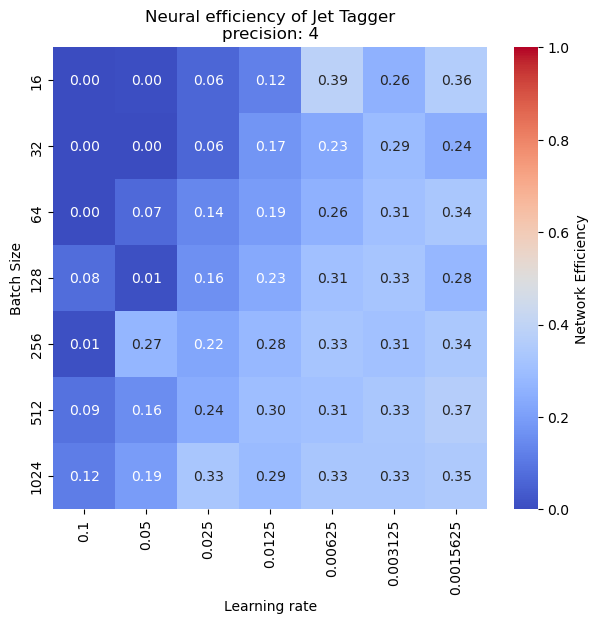

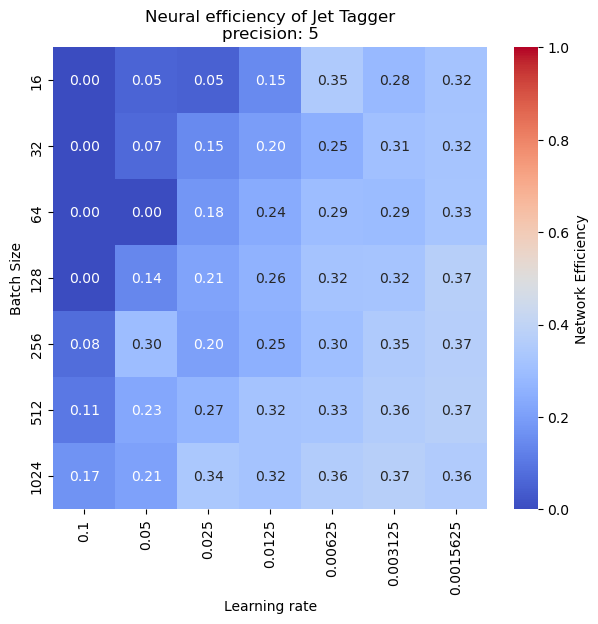

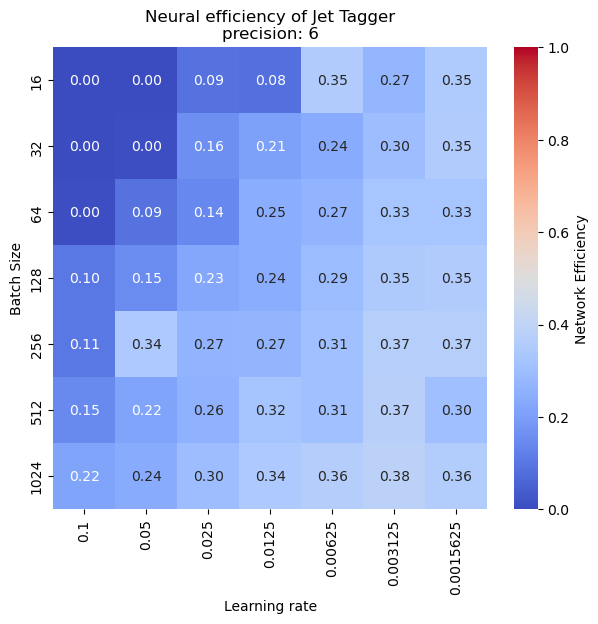

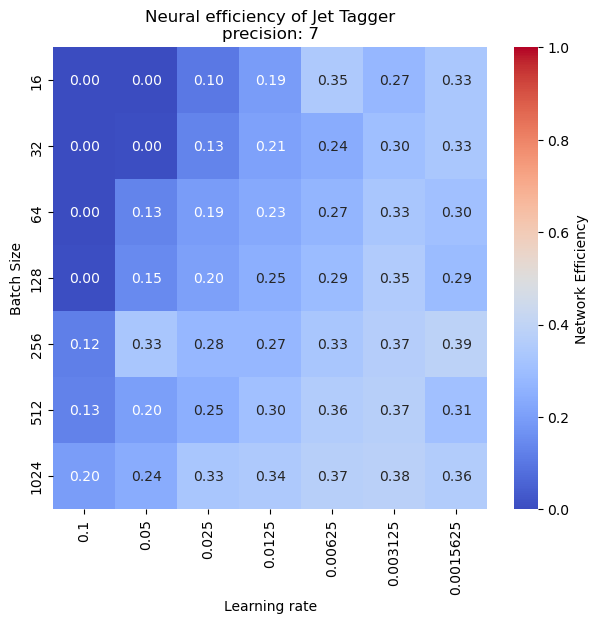

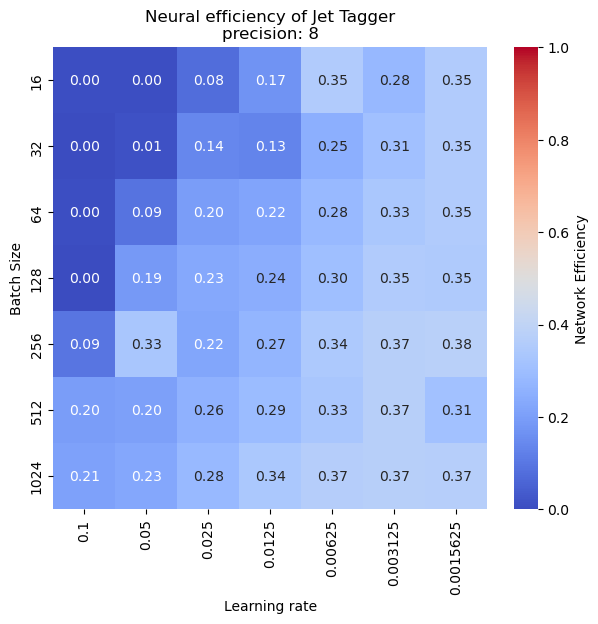

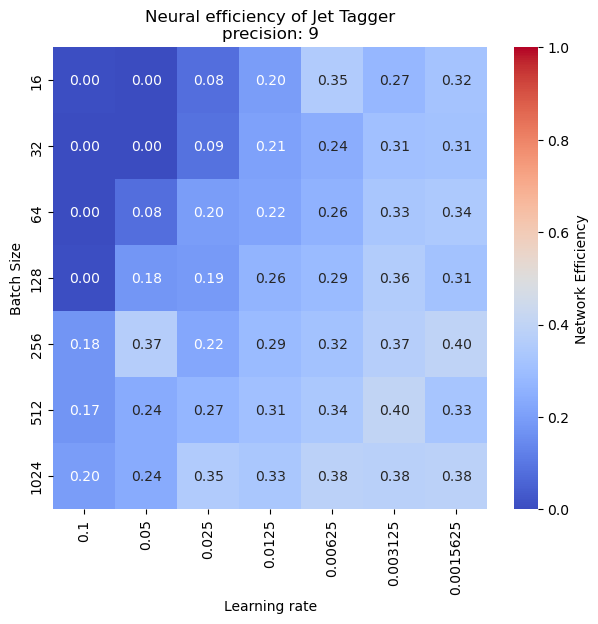

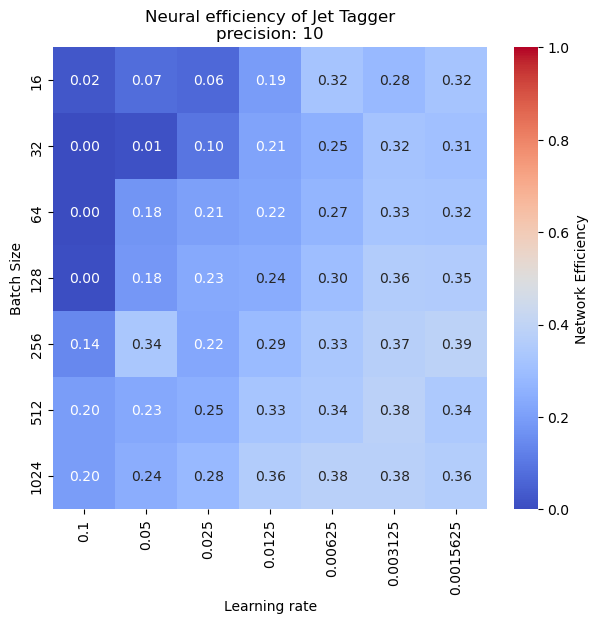

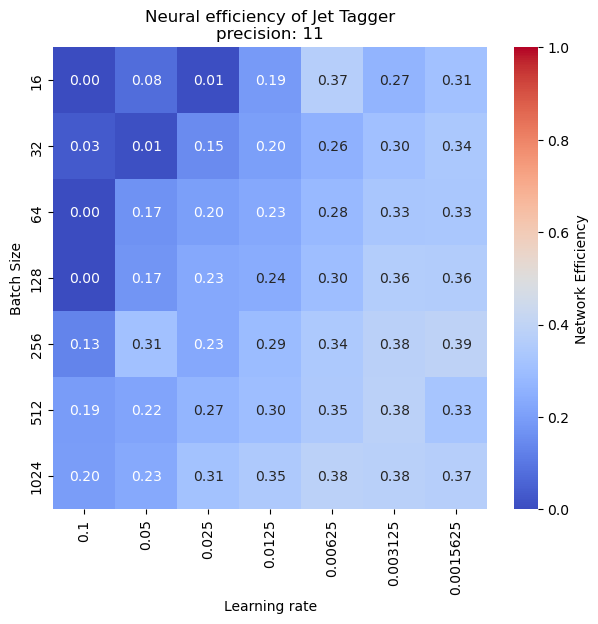

In [ ]:
ne_distribution = []
for p in precisions:
    NE_matrix = np.zeros((len(batch_sizes), len(learning_rates)))
    for x, bs in enumerate(batch_sizes):
        for y, lr in enumerate(learning_rates):
            
            # get the performances with and without noise
            mean_acc, _ = get_model_index_and_relative_accuracy(bs, lr, p)
            noise_acc = get_accuracy_with_noise(bs, lr, p, noise_type, noise)
            
            # get the model
            model, _ = load_model(bs, lr, p)
            
            # instantiate the metric
            metric = NeuralEfficiency(model, 
                                      ne_dataloader, 
                                      performance=mean_acc, 
                                      max_batches=ne_batch_num,
                                      target_layers=JTAG_layers)
            
            # load the value from the file
            path = os.path.join(
                DATA_PATH, 
                f'bs{bs}_lr{lr}/JTAG_{p}b/'
            )
            result = -1
            if metric.load_from_file(path):
                result = metric.results['network_efficiency']
                
            # build the heatmap matrix
            NE_matrix[x, y] = result
            
            # build the dataframe for further analysis
            ne_distribution.append({
                'precision': p, 
                'net_efficiency': result,
                'accuracy': mean_acc,
                'noise_acc': noise_acc,
                'batch_size': str(bs),
                'learning_rate': str(lr),
                'loss': (mean_acc - noise_acc) * 100 / mean_acc,
            })
            
    # plot the heatmaps per precision
    NE_matrix = pd.DataFrame(NE_matrix, 
                             index=batch_sizes, 
                             columns=learning_rates)
    plot_2d_heatmap(NE_matrix, 
                    f'Neural efficiency of Jet Tagger\nprecision: {p}', 
                    (0, 1),
                    'Learning rate',
                    'Batch Size',
                    'Network Efficiency',
                    cmap='coolwarm')
    


In [ ]:
ne_distribution_df = pd.DataFrame(ne_distribution)

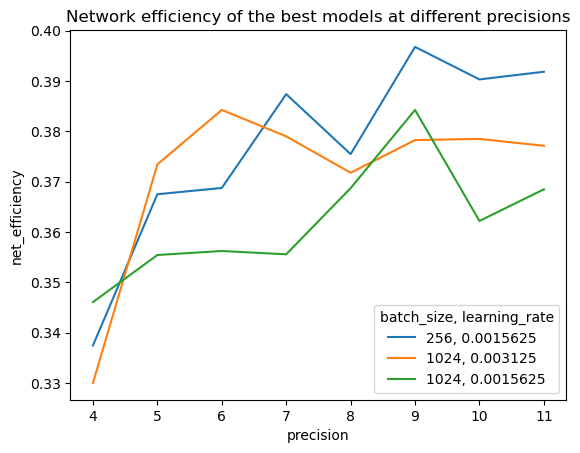

In [ ]:
top_5_df = ne_distribution_df.loc[
    (ne_distribution_df.batch_size == '1024') & (ne_distribution_df.learning_rate == '0.0015625') |
    (ne_distribution_df.batch_size == '256') & (ne_distribution_df.learning_rate == '0.0015625') |
    (ne_distribution_df.batch_size == '256') & (ne_distribution_df.learning_rate == '0.0015625') |
    (ne_distribution_df.batch_size == '1024') & (ne_distribution_df.learning_rate == '0.0015625') |
    (ne_distribution_df.batch_size == '1024') & (ne_distribution_df.learning_rate == '0.003125')
    ]

hue = top_5_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_5_df, x='precision', y='net_efficiency', hue=hue)
plt.title("Network efficiency of the best models at different precisions")
plt.show()

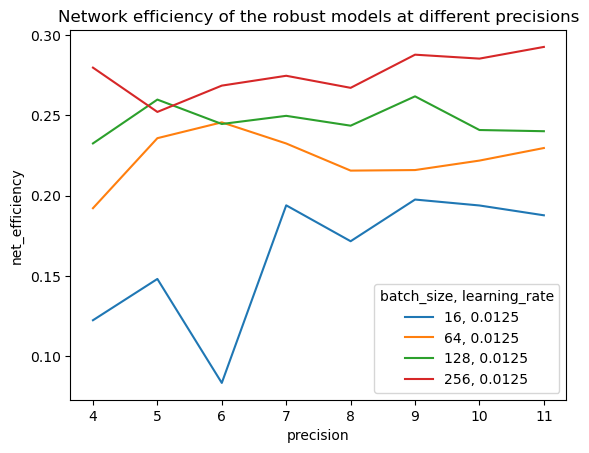

In [ ]:
top_5_df = ne_distribution_df.loc[
    (ne_distribution_df.batch_size == '16') & (ne_distribution_df.learning_rate == '0.0125') |
    (ne_distribution_df.batch_size == '64') & (ne_distribution_df.learning_rate == '0.0125') |
    (ne_distribution_df.batch_size == '256') & (ne_distribution_df.learning_rate == '0.0125') |
    (ne_distribution_df.batch_size == '16') & (ne_distribution_df.learning_rate == '0.03125') |
    (ne_distribution_df.batch_size == '128') & (ne_distribution_df.learning_rate == '0.0125')
    ]

hue = top_5_df[['batch_size', 'learning_rate']] \
        .apply(lambda row: f"{row.batch_size}, {row.learning_rate}", axis=1)
hue.name = 'batch_size, learning_rate'

sns.lineplot(top_5_df, x='precision', y='net_efficiency', hue=hue)
plt.title("Network efficiency of the robust models at different precisions")
plt.show()

## Per layer analysis

In [ ]:
MAX_LOSS = 50
MIN_ACCURACY = 0.72
NUM_PLOT = 3

ne_distribution_df = ne_distribution_df.loc[
        (ne_distribution_df.loss > -0.5) & 
        (ne_distribution_df.accuracy > MIN_ACCURACY) # &
        # (ne_distribution_df.loss < MAX_LOSS)
    ]
ne_distribution_df.sort_values(by='loss', ascending=True, inplace=True)

--------------------------------------------------------------------------------
Low loss
Accuracy:	0.7236066579818725
Loss:	0.03949883399691837
Network efficiency:	0.19751480003633723


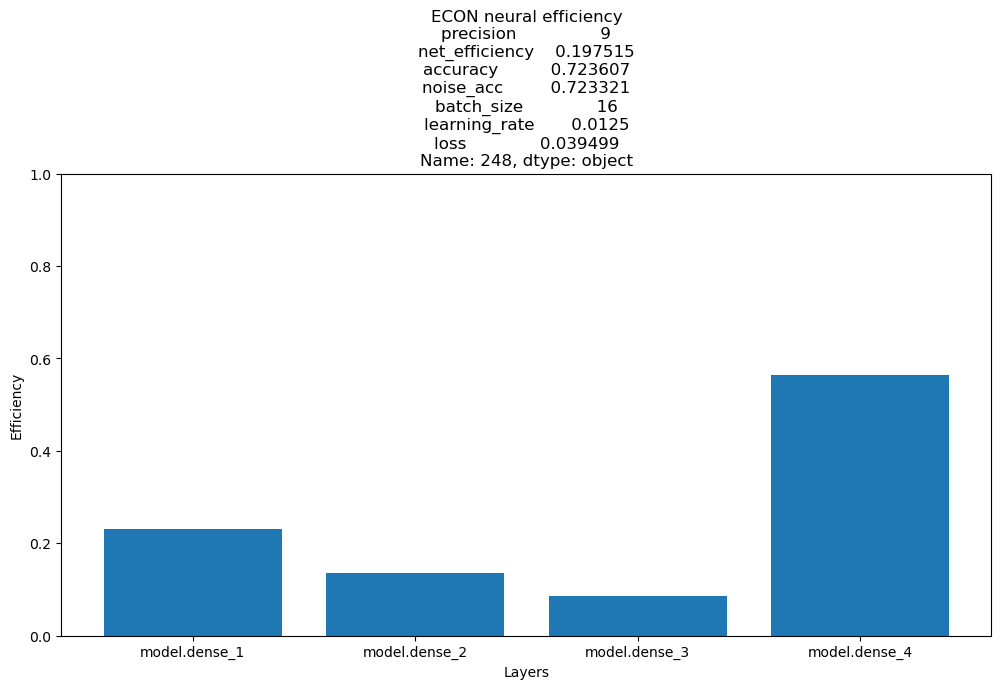

--------------------------------------------------------------------------------
Low loss
Accuracy:	0.7275750041007996
Loss:	0.329860290465477
Network efficiency:	0.14183045828436225


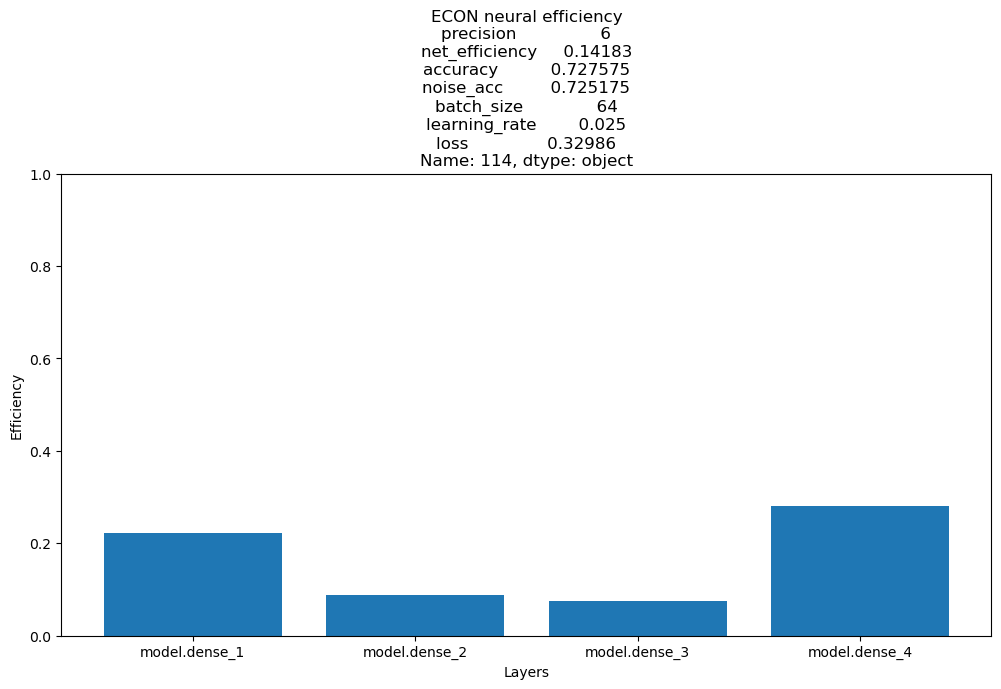

--------------------------------------------------------------------------------
Low loss
Accuracy:	0.724667489528656
Loss:	0.40201834148536963
Network efficiency:	0.2796946161622169


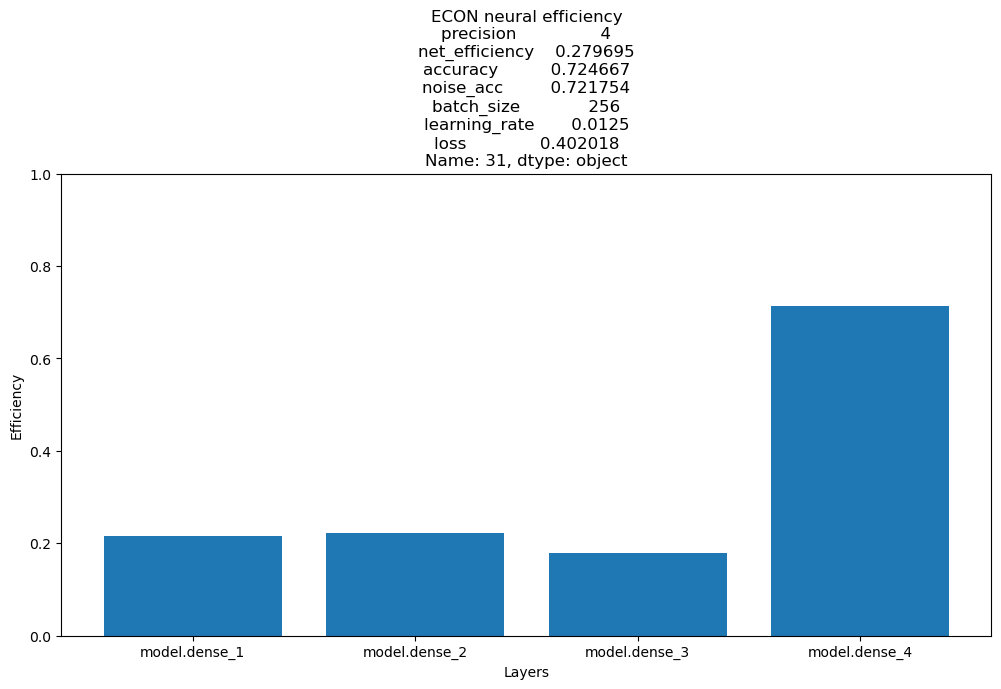

In [ ]:
best_df = ne_distribution_df.head(NUM_PLOT)
for i in range(NUM_PLOT):
    print('-'*80)
    print('Low loss')
    result = get_neural_efficiency(int(best_df.iloc[i]['batch_size']),
                                   float(best_df.iloc[i]['learning_rate']), 
                                   int(best_df.iloc[i]['precision']),
                                   ne_dataloader,
                                   max_batches=ne_batch_num)
    print(f"Accuracy:\t{best_df.iloc[i]['accuracy']}\n" \
          f"Loss:\t{best_df.iloc[i]['loss']}\n" \
          f"Network efficiency:\t{best_df.iloc[i]['net_efficiency']}")

    plot_neural_efficiency_per_layer(result['layers_efficiency'], 
                                     'ECON neural efficiency\n' \
                                     f'{best_df.iloc[i]}')

--------------------------------------------------------------------------------
High loss
Accuracy:	0.760420823097229
Loss:	73.5820620453879
Network efficiency:	0.2680655385131669


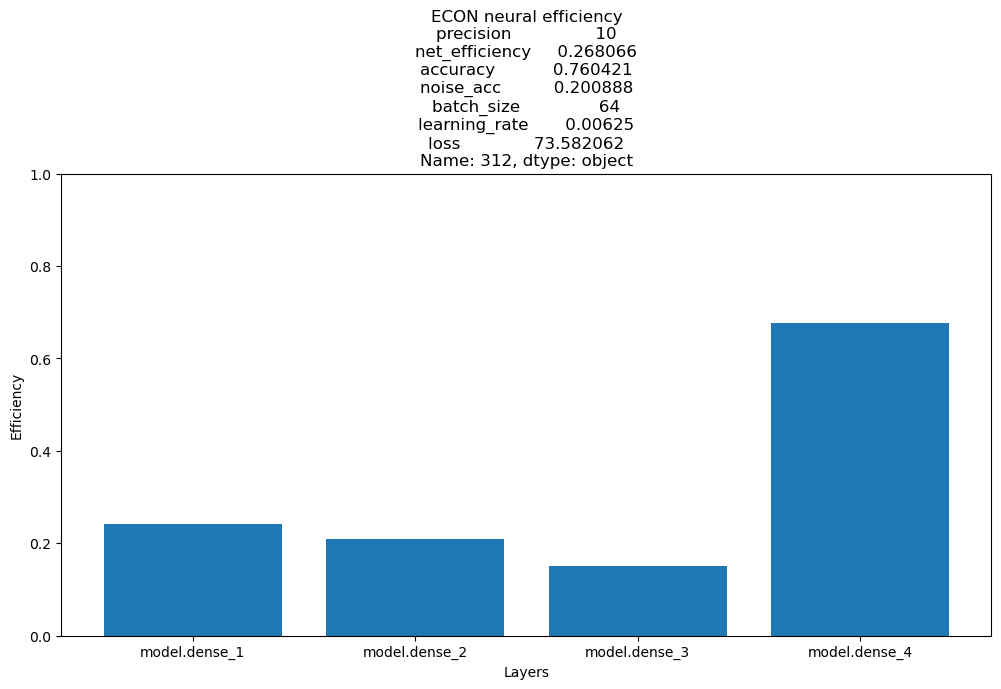

--------------------------------------------------------------------------------
High loss
Accuracy:	0.7595208406448364
Loss:	73.67528917779174
Network efficiency:	0.2668673578518543


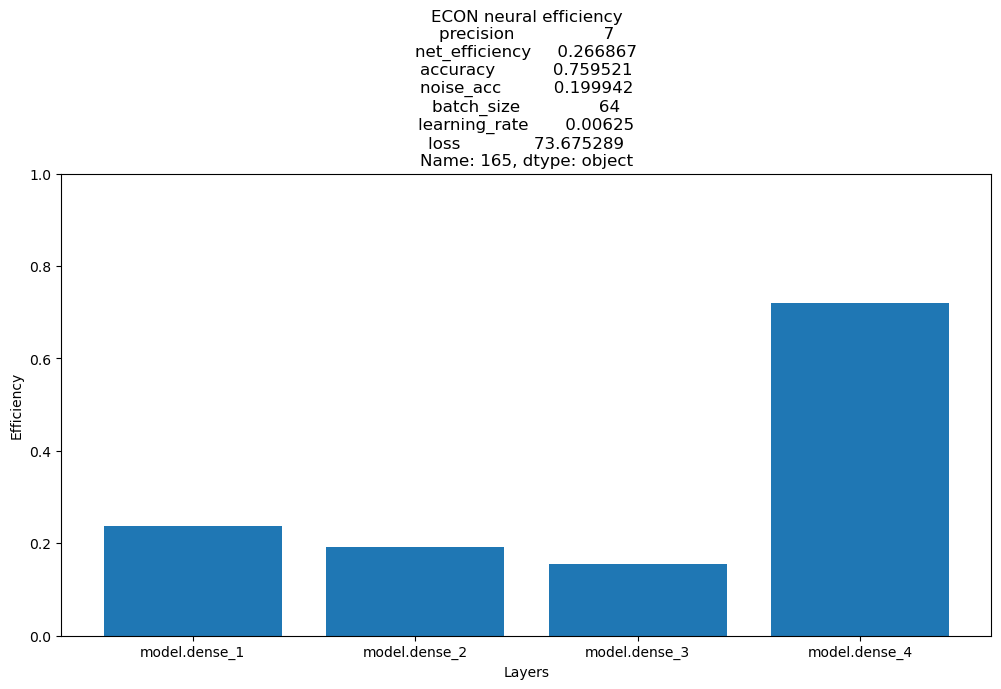

--------------------------------------------------------------------------------
High loss
Accuracy:	0.7611416697502136
Loss:	73.9585267415526
Network efficiency:	0.28256395314316163


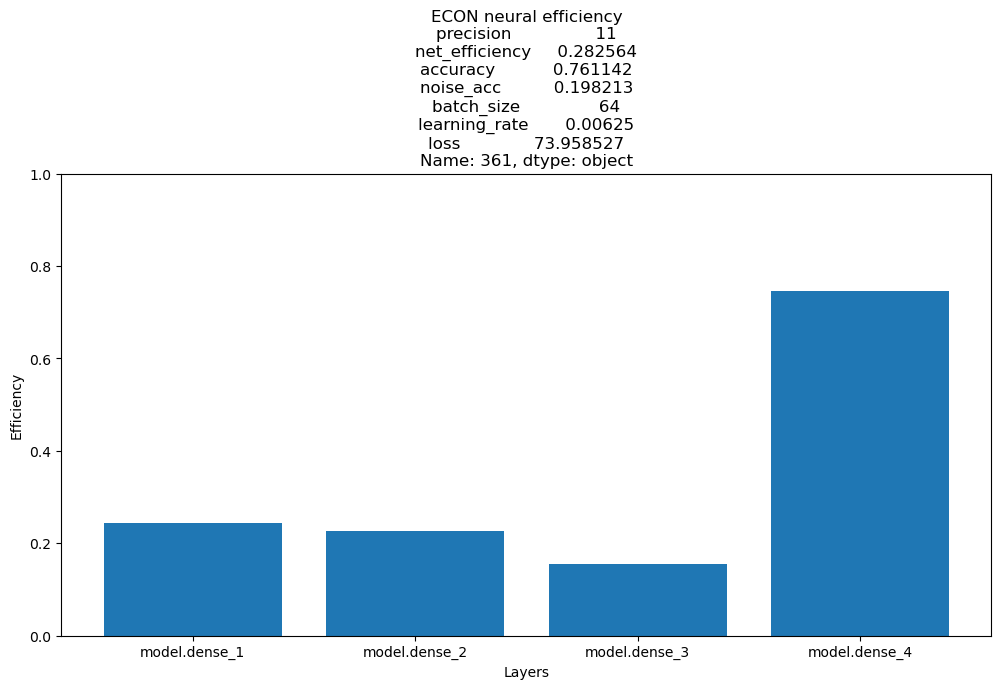

In [ ]:
worst_df = ne_distribution_df.tail(NUM_PLOT)

for i in range(NUM_PLOT):
    print('-'*80)
    print('High loss')
    result = get_neural_efficiency(int(worst_df.iloc[i]['batch_size']),
                                   float(worst_df.iloc[i]['learning_rate']), 
                                   int(worst_df.iloc[i]['precision']),
                                   ne_dataloader,
                                   max_batches=ne_batch_num)
    print(f"Accuracy:\t{worst_df.iloc[i]['accuracy']}\n" \
          f"Loss:\t{worst_df.iloc[i]['loss']}\n" \
          f"Network efficiency:\t{worst_df.iloc[i]['net_efficiency']}")

    plot_neural_efficiency_per_layer(result['layers_efficiency'], 
                                     'ECON neural efficiency\n' \
                                     f'{worst_df.iloc[i]}')